<a href="https://colab.research.google.com/github/probml/covid19/blob/master/risk-score-tuner/covid19_risk_score_tuner_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID19 Risk Score Tuner (Github version)

Kevin Murphy (kpmurphy@google.com), Stelios Serghiou (serghiou@google.com), Adam Pearce (adampearce@google.com)

go/covid-risk-score-sim-sliders

Last update: 29 September 2020

This Colab computes the probability of COVID transmission from a transmitter to a receiver, as a function of distance (estimated from bluetooth attenuation), duration, and infectiousness of the transmitter (estimated based on days since symtom onset), using a [standard exponential dose response model](http://qmrawiki.canr.msu.edu/index.php/Dose_response_assessment). The parameters of this model are derived from recent papers on the epidemiology of COVID, and on empirical bluetooth attenuation data (details below). 

In addition, the Colab computes the risk score, as defined by the [Google/ Apple Exposure Notification System](https://en.wikipedia.org/wiki/Exposure_Notification). This risk score approximates the probability of COVID transmission between two people. The score has [various parameters](https://enconfig.storage.googleapis.com/enconfig_fixed.html) that need to be set by the public health authority. This Colab lets the user visualize the effect of changing these parameters, as compared to the above model. 


In [3]:
import itertools
from dataclasses import dataclass
import collections
from collections import namedtuple

import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.cm as cm 

import sklearn
from sklearn import metrics



## Probability of COVID transmission




The probability of transmitting the virus from transmitter to receiver is given by a [standard exponential dose response model](http://qmrawiki.canr.msu.edu/index.php/Dose_response_assessment).

$$
\begin{align}
p(y=1|x) &= 1-e^{-\beta \; h(x)} \\
h(x) &= t \times f_{\text{dist}}(d)
\times f_{\text{inf}}(\Delta)
\end{align}
$$

where $x=(t,d,\Delta)$ is the exposure defined in terms of duration $t$, distance $d$ and days since symptom onset $\Delta$, and $h(x)$ is the hazard function, which computes the viral dose that is received.

We define $f_{\text{dist}}(d)$ and $f_{\text{inf}}(\Delta)$ below.
We also explain how to infer distance from bluetooh attenuation.

We set $\beta$ by hand, so that $p(y=1|x)=0.3$ when $t=8$ hours, $d=2$ m, and $\Delta=0$, to match the empirical attack rate in Wilson (2020).

The probability that the receiver gets infected is equal to the susceptibility times the probability of transmission. Susceptbility depends on many factors, such as the age of the receiver, whether they are wearing a mask, etc. We do not model this, since it is not part of the GAEN system.

* [Quantifying SARS-CoV-2-infection risk withing the Apple/Google exposure notification framework to inform quarantine recommendations](https://www.medrxiv.org/content/10.1101/2020.07.17.20156539v1), Amanda Wilson, Nathan Aviles,  Paloma  Beamer, Zsombor Szabo, Kacey  Ernst, Joanna Masel. July 2020.
[Code](https://github.com/awilson12/risk_scoring).



## Viral transmission vs distance

### Quadratic model


Briers (2020) propose the following quadratic model 
$$
f_{\text{dist}}(d) =  \min(1, D^2_{\min}/d^2)
 $$

They set
$D^2_{\min}=1$  based on argument of the physics of droplet spread.
However, we make this parameter adjustable, to capture the possibility of longer-range aerosal tranmissions.

* [Risk scoring in contact tracing apps](https://drive.google.com/file/d/14v9aCBzv5OehFQfQqs9a7xZhdjlKmszd/view?usp=sharing), Mark Briers, Marcos Charalambides, Christophe Fraser, Chris Holmes, Radka Jersakova, James Lomax, and Tom Lovett. 26 July 2020

In [4]:
def transmission_vs_distance_quadratic(d, Dmin=1):
  m = np.power(Dmin,2)/np.power(d, 2)
  return np.minimum(1, m)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0, 0.5, 'distance factor')

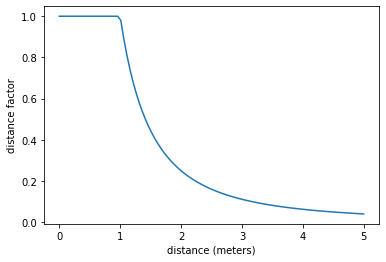

In [5]:

d = np.linspace(0, 5, 100)
p = transmission_vs_distance_quadratic(d)
plt.figure()
plt.plot(d, p)
plt.xlabel('distance (meters)');
plt.ylabel('distance factor')




### Sigmoid model

Cencetti propose the following sigmoidal decay function to encode the risk at different distances:


$$
f_{\text{dist}}(d) = 1-\frac{1}{1+\exp(-a d + b)}
 $$

They heuristically set $a = 1.5$ and $b=6.6$ so that the factor is $\approx 1$ for $d < 2$, $0.5$ at $d=4.4$ and $\approx 0$ for $d \geq 10$ (where $d$ is in meters).


* [Digital Proximity Tracing in the COVID-19 Pandemic on Empirical Contact Networks](https://www.medrxiv.org/content/10.1101/2020.05.29.20115915v2)
Giulia Cencetti et al., June 2020. [Code](https://github.com/DigitalContactTracing/covid_code)

To make these parameters more intuitive, and easier to adjust, we reparameterize the model in terms of its slope $w$, and its inflection point
$c$, which is where the curve crosses 0.5:

$$
f_{\text{dist}}(d) = 1-\frac{1}{1+\exp(-w d + w c)}
 $$



In [6]:
def transmission_vs_distance_sigmoid(distance, slope=2, inflection=2):
  return 1-1/(1+np.exp(-slope*distance + slope*inflection))

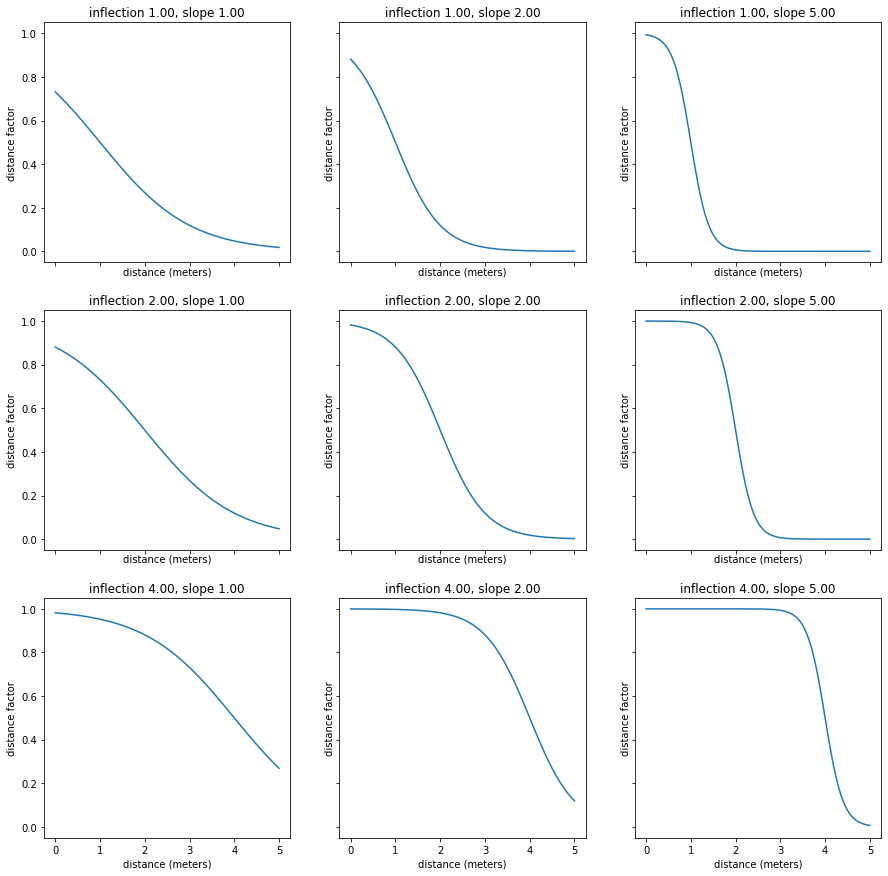

In [7]:
d = np.linspace(0, 5, 100)
inflections = [1,2,4]
slopes = [1,2,5]
m = len(inflections)
n = len(slopes)
fig, axs = plt.subplots(m,n, figsize=(5*n,5*m), sharex=True, sharey=True)
#axs = np.reshape(axs, (n,))
for i in range(m):
  inflection = inflections[i]
  for j in range(n):
    ax = axs[i,j]
    slope = slopes[j]
    p = transmission_vs_distance_sigmoid(d, slope=slope, inflection=inflection)
    ax.plot(d, p)
    ax.set_title('inflection {:0.2f}, slope {:0.2f}'.format(inflection, slope))
    ax.set_xlabel('distance (meters)');
    ax.set_ylabel('distance factor')

## Infectiousness vs time since symptom onset



Suppose Bob gets infected and shows symptoms at time $T^s$.
Then Bob meets Alice, who gets exposed at time $T^e$.
Let $\Delta=T^e - T^s$ be time since onset of symptoms (TOST) for Bob. Let $f_{\rm{inf}}(\Delta)$ be the infectiousness as a function of TOST. We give two version of this function below.

### Gaussian approximation





We use the Gaussian approximation from the following paper.

* [Risk scoring in contact tracing apps](), Mark Briers, Marcos Charalambides, Christophe Fraser, Chris Holmes, Radka Jersakova, James Lomax, and Tom Lovett. 26 July 2020


$$
f_{inf}(\Delta) = \exp\left( 
  -\frac{ (\Delta - \mu)^2 }{2 \sigma^2} \right) 
$$

where   $\mu=-0.3$ , $\sigma=2.75$ (units of days). 

In [8]:
def infectiousness_gaussian(deltas):
  mu = -0.3; s = 2.75;
  ps = np.exp(- np.power(deltas-mu,2) / (2*s*s))
  return ps



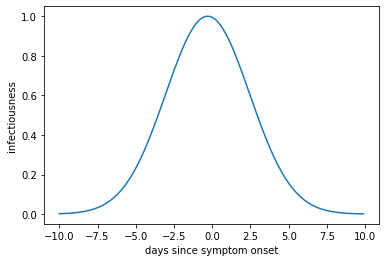

In [9]:
deltas = np.arange(-10, 10, 0.1)
ps = infectiousness_gaussian(deltas)
plt.figure();
plt.plot(deltas, ps)
plt.xlabel('days since symptom onset');
plt.ylabel('infectiousness');

### Skew-logistic distribution





We use the skew-logistic distributions proposed in Ferretti'20, which captures dependency between infectiousness and incubation period. 


* [The timing of COVID-19 transmission](https://www.medrxiv.org/content/10.1101/2020.09.04.20188516v1.abstract), Luca Ferretti et al, Sept. 2020

Since the incubation period is unknown, we marginalize it out, using the log-normal distribution from this paper:


* [The Incubation Period of Coronavirus Disease 2019 (COVID-19) From Publicly Reported Confirmed Cases: Estimation and Application](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7081172/), Stephen Lauer et al, March 2020.

$$
\begin{align}
f_{inf}(\Delta) &= \int \text{SkewLogistic}(\Delta|t_i; \mu=-4.00, \sigma=1.85, \alpha=5.85) \\
&\times \text{LogNormal}(t_i|\mu=1.644,\sigma=0.363) \; d t_i
\end{align}
$$

where $\Delta$ is time since onset of symptoms (TOST).

In [10]:
def skew_logistic_scaled(x, alpha, mu, sigma):
  return scipy.stats.genlogistic.pdf(x, alpha, loc=mu, scale=sigma)
    
def ptost_conditional(ts, incubation):
  mu = -4
  sigma = 1.85
  alpha = 5.85
  tau = 5.42
  fpos = skew_logistic_scaled(ts, alpha, mu, sigma)
  #fneg = skew_logistic_scaled(ts, alpha, mu, sigma*incubation/tau) # error in paper
  # Version below is correct (Ferretti, personal communication)
  fneg = skew_logistic_scaled(ts*tau/incubation, alpha, mu, sigma)
  ps = fpos
  neg = np.where(ts < 0)
  ps[neg] = fneg[neg]
  ps = ps/np.max(ps)
  return ps

def incubation_dist(t):
  mu = 1.621
  sig = 0.418
  rv = scipy.stats.lognorm(sig, scale=np.exp(mu))
  return rv.pdf(t)

def ptost_uncond(tost_times):
  #p(t) = sum_{k=1}^14 p(incubation=k) ptost(t | k) / max_t( ptost(t|k) )
  incub_times = np.arange(1, 14, 1)
  incub_probs = incubation_dist(incub_times) 
  tost_probs = np.zeros_like(tost_times, dtype=float)
  for k, incub in enumerate(incub_times):
    ps = ptost_conditional(tost_times, incub)
    tost_probs += incub_probs[k] * ps
  #tost_probs = tost_probs/np.max(tost_probs)
  return tost_probs

infectiousness_curve_times = np.arange(-14, 14+1, 0.1)
infectiousness_curve_vals = ptost_uncond(infectiousness_curve_times)

def infectiousness_skew_logistic(delta):
  return np.interp(delta, infectiousness_curve_times, infectiousness_curve_vals)


Text(0, 0.5, 'prob(transmission)')

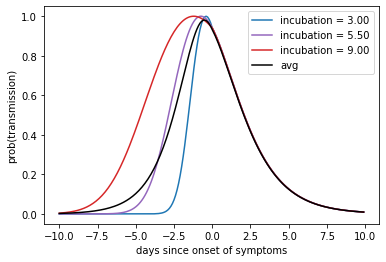

In [11]:
tost = np.arange(-10, 10, 0.1)
incubs = np.array([3, 5.5, 9])
#https://matplotlib.org/3.1.1/tutorials/colors/colors.html
colors = ['tab:blue', 'tab:purple', 'tab:red']
plt.figure()
for i, incub in enumerate(incubs):
  ps = ptost_conditional(tost, incub)
  #ps = ps/np.max(ps)
  name = 'incubation = {:0.2f}'.format(incub)
  plt.plot(tost, ps, label=name, color=colors[i])
ps = ptost_uncond(tost)
ps = [infectiousness_skew_logistic(t) for t in tost]
qs = infectiousness_skew_logistic(tost)
assert np.allclose(ps, qs)
plt.plot(tost, ps, label='avg', color='k')
plt.legend()
plt.xlabel('days since onset of symptoms')
plt.ylabel('prob(transmission)')

## Bluetooth simulator




We use the discriminative log-normal regression model from Figure 4 of the Lovett paper,
which was fit to [H0H1 data from MIT Lincoln Labs](https://github.com/mitll/H0H1). 


* [Inferring proximity from Bluetooth Low Energy RSSI with Unscented Kalman Smoothers](https://arxiv.org/abs/2007.05057), Tom Lovett, Mark Briers, Marcos Charalambides, Radka Jersakova, James Lomax, Chris Holmes, July 2020.

Let  $A(d)=t_x - r_x - R(d)$ be the attenuation at distance $d$, where $R(d)$ is the RSSI, $t_x$ is the transmitter strength, $r_x$ is the receiver strength, (aka correction factor), and $t_x - r_x = 2.398$.

We assume
$$
\begin{align}
X(d) &=\log(-R(d))\\
X(d) &\sim N(\mu(d),\sigma) \\
\mu(d) &= w \log(d) + b
\end{align}
$$
 where 
$w=0.21$,  $b=3.92$ and $\sigma^2=0.33$.

To compute the expected distance $d$ from attenuation $A$, we first compute $R$ from $A$, and then invert the equation for the mean:
$$
\begin{align}
\log(-R) &= w \log(d) + b \\
d &= \exp( (\log(-R) - b)/w ) 
\end{align}
$$

In [12]:
@dataclass
class BleParams:
  slope: float = 0.21
  intercept: float = 3.92
  sigma: float = np.sqrt(0.33)
  tx: float = 0.0
  correction: float=2.398
  name: str = 'briers-lognormal'


def atten_to_dist(atten, params):
  rssi = params.tx  - (atten + params.correction)
  return np.exp((np.log(-rssi) - params.intercept)/params.slope)

def dist_to_atten(distance, params):
  mu = params.intercept + params.slope * np.log(distance)
  rssi = -np.exp(mu)
  atten = params.tx  - (rssi + params.correction)
  return atten

def dist_to_atten_sample(distances, params):
    if params.sigma == 0:
      return dist_to_atten(distances, params)
    N = len(distances)
    mus = params.intercept + params.slope * np.log(distances)
    sigs = params.sigma
    rssi = -scipy.stats.lognorm(s=sigs, scale=np.exp(mus)).rvs()
    atten = params.tx  - (rssi + params.correction)
    return atten

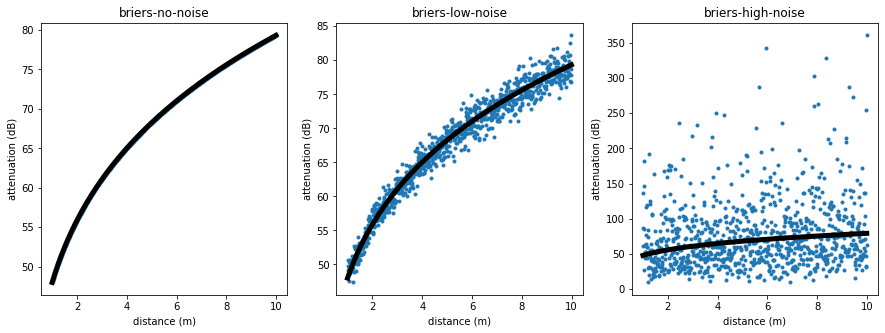

In [13]:

ble_params_mle = BleParams(sigma=np.sqrt(0.33), name = 'briers-high-noise')
ble_params_low_noise = BleParams(sigma=0.02, name = 'briers-low-noise')
ble_params_no_noise = BleParams(sigma=0, name = 'briers-no-noise')

ble_params_list = [ble_params_no_noise, ble_params_low_noise, ble_params_mle]

distances  = np.arange(1, 10, 0.01)

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs = np.reshape(axs, (3,))
for i, params in enumerate(ble_params_list):
    mu = dist_to_atten(distances, params)
    np.random.seed(0)
    attens = dist_to_atten_sample(distances, params)
    ax = axs[i]
    ax.plot(distances, attens, '.')
    ax.plot(distances, mu, 'k-', lw=5)
    ax.set_ylabel('attenuation (dB)')
    ax.set_xlabel('distance (m)')
    ax.set_title(params.name)

## Transmission model

In [14]:
@dataclass
class ModelParams:
  ble_params: BleParams = BleParams() # may want to change sigma
  distance_fun: str = 'sigmoid' # quadratic  or sigmoid
  distance_Dmin: float = 1.0
  distance_slope: float = 1.5
  distance_inflection: float = 4.4
  infectiousness_fun: str = 'skew-logistic' # gaussian or skew-logistic
  beta: float = 1e-3 # transmission rate

def prob_infection_batch(attenuations, durations, symptom_days, params, distances=None):
  if distances is None:
    distances = atten_to_dist(attenuations, params.ble_params)
  if params.distance_fun == 'quadratic':
    fd = transmission_vs_distance_quadratic(distances, params.distance_Dmin)
  elif params.distance_fun == 'sigmoid':
    fd = transmission_vs_distance_sigmoid(distances, params.distance_slope, params.distance_inflection)
  if params.infectiousness_fun == 'gaussian':
    finf = infectiousness_gaussian(symptom_days) 
  elif params.infectiousness_fun == 'skew-logistic':
    finf = infectiousness_skew_logistic(symptom_days)
  doses  = durations * fd * finf 
  return 1-np.exp(-params.beta * doses)

params = ModelParams()
print(params)

ModelParams(ble_params=BleParams(slope=0.21, intercept=3.92, sigma=0.5744562646538028, tx=0.0, correction=2.398, name='briers-lognormal'), distance_fun='sigmoid', distance_Dmin=1.0, distance_slope=1.5, distance_inflection=4.4, infectiousness_fun='skew-logistic', beta=0.001)


## Risk score model

Consider a single exposure event $x=(t, a, \Delta)$, where $t$ is the duration (in minutes), $a$ is the attenuation, and $\Delta$ is the days since symptom onset.
Let $b(a)$ be the bucket into which the attenuation falls (based on the specified thresholds $\theta$), and let $i(\Delta)$ be the infectiousness level (based on the sympton onset mapping $\Psi$). The GAEN API defines the risk  in terms of effective exposure minutes, as follows:

$$
r(x; w,\theta,\Psi) = t \times w_b^{\text{atten}} \times w_i^{\text{inf}}
$$

The parameters $w$, $\theta$ and $\psi$ are specified by the configuration file provided by the PHA (see below).

We can convert this to a probability of infection using

$$
q(y=1|x) = 1-e^{-\beta \; r(x)}
$$
Thus we interpret the risk score as an approximation to the dose (hazard) function. Following Wilson, we set $\beta=3.1 \times 10^{-6}$, which gives a probability of infection after 8h of exposure to a maximally infectious person at the minimal attenuation bucket of 0.3, which matches the empirical attack rate for at-home exposures.

* [Quantifying SARS-CoV-2-infection risk withing the Apple/Google exposure notification framework to inform quarantine recommendations](https://www.medrxiv.org/content/10.1101/2020.07.17.20156539v1), Amanda Wilson, Nathan Aviles,  Paloma  Beamer, Zsombor Szabo, Kacey  Ernst, Joanna Masel. July 2020

In [15]:

@dataclass
class RiskConfig:
    ble_thresholds: np.array  = np.array([])
    ble_weights: np.array  = np.array([])
    inf_levels: np.array  = np.array([])
    inf_weights: np.array  = np.array([])
    name: str = ''
    beta: float = 3.1 * 1e-6 # Wilson table 1

def get_one_hot(targets, num_classes):
  # https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
  I = np.eye(num_classes)
  r = np.atleast_1d(targets)
  res = I[r]
  s = list(r.shape) + [num_classes]
  return res.reshape(s)


def infectiousness_score_batch(symptom_days, inf_levels, inf_weights): 
  # Map each symptom onset day to a level, and return the correspond weights.
  # symptom_days is an array of ints in -14..14
  symptom_days = np.atleast_1d(symptom_days)
  inf_labels = inf_levels[symptom_days + 14]
  inf_vecs = get_one_hot(inf_labels, num_classes = len(inf_weights))
  tmp = np.multiply(inf_weights, inf_vecs)
  scores = np.sum(tmp, 1)
  return scores

def attenuation_score_batch(attenuations, thresholds, weights):
  # Map each attenuation to the corresponding bucket
  # and return the corresponding set of weights.
  attenuations = np.atleast_1d(attenuations)
  labels = np.digitize(attenuations, thresholds)
  vecs = get_one_hot(labels, num_classes = len(weights))
  tmp = np.multiply(weights, vecs)
  scores = np.sum(tmp, 1)
  return scores

def risk_score_batch(attenuations, durations, symptom_days, config):
  attenuations = np.atleast_1d(attenuations)
  durations = np.atleast_1d(durations)
  symptom_days = np.atleast_1d(symptom_days)
  winf = infectiousness_score_batch(symptom_days, config.inf_levels, config.inf_weights)
  watten = attenuation_score_batch(attenuations, config.ble_thresholds, config.ble_weights)
  risks = durations * watten * winf
  return risks

def prob_risk_score_batch(attenuations, durations, symptom_days, config):
  risks = risk_score_batch(attenuations, durations, symptom_days, config)
  probs = 1-np.exp(-config.beta * risks)
  return probs

# Specify risk configurations

## Attenuation thresholds

In [16]:
# Thresholds and weights for v1 of the API
ble_swiss = RiskConfig(ble_thresholds = np.array([53, 60]),
                          ble_weights = np.array([1.0, 0.5, 0.0]),
                          name= 'Switzerland')

ble_germany = RiskConfig(ble_thresholds = np.array([55, 63]),
                            ble_weights = np.array([1.0, 0.5, 0.0]),
                            name= 'Germany')

ble_ireland = RiskConfig(ble_thresholds = np.array([56, 62]),
                            ble_weights = np.array([1.0, 1.0, 0.0]),
                            name= 'Ireland')

ble_arizona = RiskConfig(ble_thresholds = np.array([50, 70]),
                           ble_weights = np.array([2.39, 0.6, 0.06]),
                           name = 'Arizona')

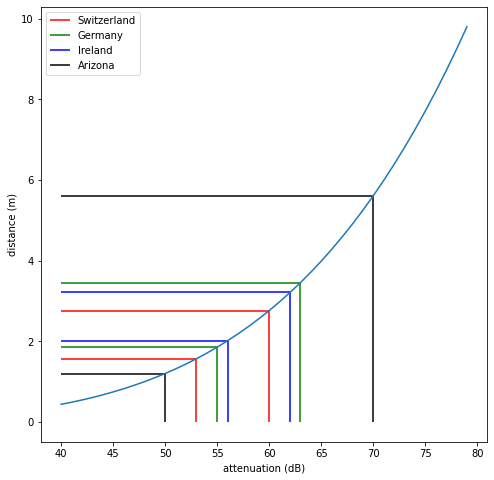

In [17]:
ble_list = [ble_swiss, ble_germany, ble_ireland, ble_arizona]

attens = np.arange(40, 80)
ble_params = BleParams()
distances = atten_to_dist(attens, ble_params)

fig, axs = plt.subplots(1,1, figsize=(8,8))
axs = np.reshape(axs, (1,))
ax = axs[0]
ax.plot(attens, distances)
ax.set_xlabel('attenuation (dB)')
ax.set_ylabel('distance (m)')
                
names = [config.name for config in ble_list]
colors = ['r', 'g', 'b', 'k']
handles = []
for i, config in enumerate(ble_list):
    for j, thresh in enumerate(config.ble_thresholds):
      dist =  atten_to_dist(thresh, ble_params)
      handle = ax.vlines(thresh, 0, dist, color=colors[i])
      ax.hlines(dist, np.min(attens), thresh, color=colors[i])
      if j==0:
        handles.append(handle)
ax.legend(handles, names)
plt.show()

## Infectiousness levels



Below we map the days since sympton onset to an infectiousness level.
We consider two versions of this. For the v1 API, we use the parameters from Wilson's paper, which uses 6 levels. For the v2 API, we simplify the Wilson parameters down to 2 levels.


* [Quantifying SARS-CoV-2-infection risk withing the Apple/Google exposure notification framework to inform quarantine recommendations](https://www.medrxiv.org/content/10.1101/2020.07.17.20156539v1), Amanda Wilson, Nathan Aviles,  Paloma  Beamer, Zsombor Szabo, Kacey  Ernst, Joanna Masel. July 2020

Figure below from this paper are settings for v1 of Arizona's [CovidWatch app](https://www.covidwatch.org/).


<img src="https://github.com/probml/covid19/blob/master/Figures/infectiousness-TOST-MaselFig5A.png?raw=true">


In [18]:
def make_infectiousness_params_v1():
  # Arizona settings
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0, 10**1, 10**1.2, 10**1.4, 10**1.6, 10**1.8, 10**2])
  return inf_levels, inf_weights

def make_infectiousness_params_v2():
  # Derived from Arizona
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid6 = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_mid = np.ones_like(inf_mid6)
  ndx = (inf_mid6 >= 5)
  inf_mid[ndx] = 2
  #inf_mid = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0,  10**1.6, 10**2])
  return inf_levels, inf_weights

def make_infectiousness_params_v0():
  # Currently PHAs ignore exposures with sympton onset earlier than -2 days.
  # Apart from that, they treat all infectiousness levels equally.
  n = 29 # -14..14 is 29
  levels = [0] * 12 + [1] * (n-11) + [0]
  levels = np.array(levels)
  weights = np.array([0,1,1]) # drop, standard, high
  return levels, weights



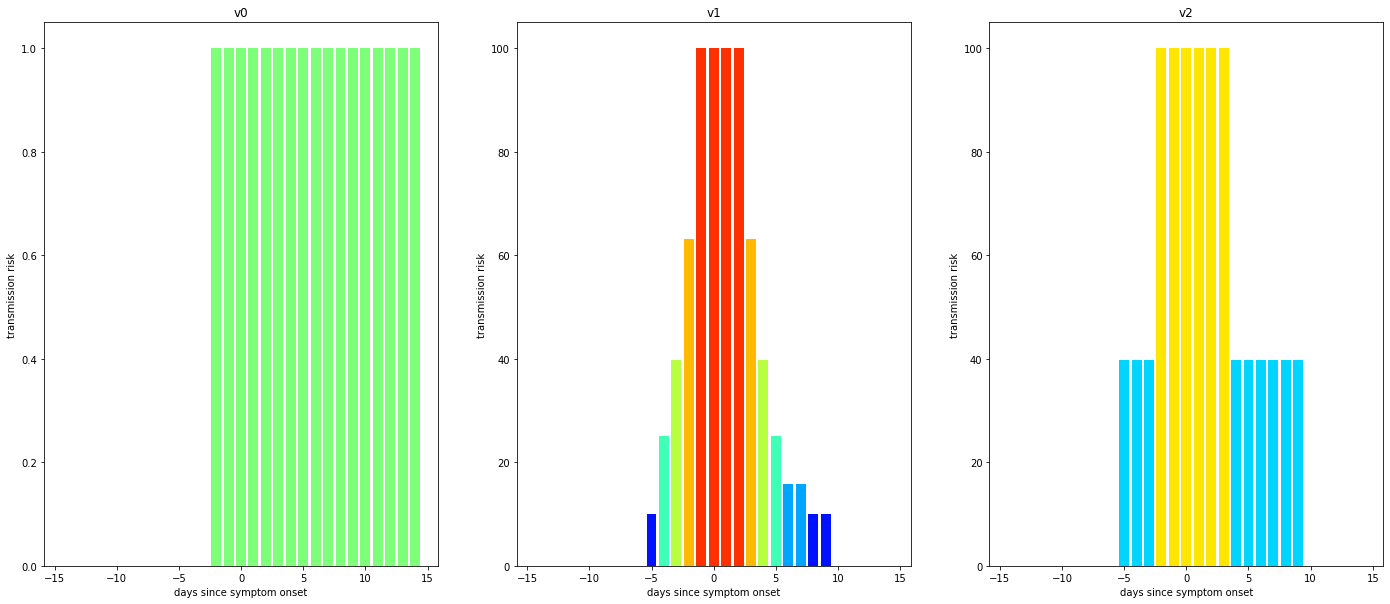

In [19]:
import matplotlib.cm as cm 
cmap = cm.get_cmap('jet')
ts = np.arange(-14, 14+1, 1)
levels0, weights0 = make_infectiousness_params_v0()
levels1, weights1 = make_infectiousness_params_v1()
levels2, weights2 = make_infectiousness_params_v2()

name_list = ['v0', 'v1', 'v2']
level_list = [levels0, levels1, levels2]
weight_list = [weights0, weights1, weights2]

n = len(level_list)
fig, axs = plt.subplots(1,n, figsize=(8*n,10))
axs = np.reshape(axs, (n,))

for i in range(n):
  levels = level_list[i]  
  weights = weight_list[i]
  name = name_list[i]
  ps = infectiousness_score_batch(ts, levels, weights) 
  nlevels = len(np.unique(levels))
  colors = [cmap(c/nlevels) for c in levels]     
  ax = axs[i]                                         
  ax.bar(ts, ps, color = colors)
  ax.set_xlabel('days since symptom onset');
  ax.set_ylabel('transmission risk');
  ax.set_title(name)



## Published configurations

In [20]:
# Published configs are just for v1 of the API


# Currently most PHAs ignore exposures with sympton onset earlier than -2 days.
# Apart from that, they treat all infectiousness levels equally.
n = 29 # -14..14 is 29 (we ignore the case when symptom onset is unknown)
levels = np.array([0] * 12 + [1] * (n-11) + [0])
weights = np.array([0,1,1]) # drop, standard, high


config_swiss = RiskConfig(ble_thresholds = np.array([55, 63]),
                          ble_weights = np.array([1.0, 0.5, 0.0])*100,
                          inf_weights = weights,
                          inf_levels = levels,
                          name= 'Switzerland')

# config_germany = RiskConfig(ble_thresholds = np.array([55, 63]),
#                            ble_weights = np.array([1.0, 0.5, 0.0])*100,
#                            inf_weights = weights,
#                            inf_levels = levels,
#                            name= 'Germany')

config_ireland = RiskConfig(ble_thresholds = np.array([56, 62]),
                            ble_weights = np.array([1.0, 1.0, 0.0])*100,
                            inf_weights = weights,
                            inf_levels = levels,
                            name= 'Ireland')

config_virginia = RiskConfig(ble_thresholds = np.array([55, 63]),
                          ble_weights = np.array([1.0, 0.5, 0.0])*100,
                          inf_weights = weights,
                          inf_levels = levels,
                          name= 'Virginia')






In [21]:
def make_ble_params_v1():
  # Arizona parameters
  thresholds = np.array([50, 70])
  weights = np.array([2.39, 0.6, 0.06])
  return thresholds, weights

def make_ble_params_v2():
  # Extrapolated from Arizona parameters
  thresholds = np.array([50, 70, 80])
  weights = np.array([2.39, 0.6, 0.06, 0.01])
  return thresholds, weights


levels, weights = make_infectiousness_params_v1()
thresholds, ble_weights = make_ble_params_v1()
config_arizona = RiskConfig(ble_thresholds = thresholds,
                            ble_weights = ble_weights,
                            inf_weights = weights,
                            inf_levels = levels,
                            name = 'Arizona')


# Baseline config is derived from Arizona.
levels, weights = make_infectiousness_params_v2()
thresholds, ble_weights = make_ble_params_v2()
config_baseline = RiskConfig(ble_thresholds = thresholds,
                            ble_weights = ble_weights,
                            inf_weights = weights,
                            inf_levels = levels,
                            name = 'Baseline')

# Static plots

## Make grid of possible inputs

In [22]:
ble_params = BleParams()
def make_inputs():
  #attens = np.linspace(40, 80, 10, endpoint=True)
  distances = np.linspace(0.5, 5, 20, endpoint=True)
  attens = dist_to_atten(distances, ble_params)
  durations = np.linspace(1, 1*60, 10, endpoint=True)
  symptoms = np.arange(-5, 10) # must be int
  return attens, durations, symptoms

def make_input_grid():
  attens, durations, symptoms = make_inputs()
  vals = itertools.product(durations, attens, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  durations_grid = X[:,0]
  attens_grid = X[:,1]
  sym_grid = np.array(X[:,2], dtype=int)
  return durations_grid, attens_grid, sym_grid




Text(0, 0.5, 'duration (mins)')

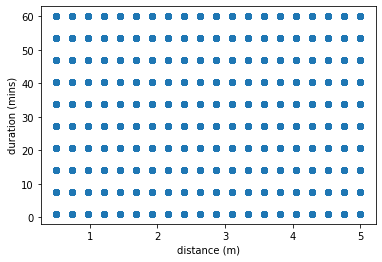

In [23]:
durations_grid, attens_grid, sym_grid = make_input_grid()
ble_params = BleParams()
distances_grid = atten_to_dist(attens_grid, ble_params)
plt.figure()
plt.scatter(distances_grid, durations_grid)
plt.xlabel('distance (m)')
plt.ylabel('duration (mins)')


## Plot risk / hazard surfaces

In [24]:
def plot_risk_vs_symptoms(attens, dur, symptoms, config, params, ax):
  cmap = cm.get_cmap('plasma')
  nattens = len(attens)
  colors = [cmap(c/nattens) for c in range(nattens)]
  for j, atten in enumerate(attens):
    ps = prob_infection_batch(atten, dur, symptoms, params)
    qs = prob_risk_score_batch(atten, dur, symptoms, config)
    label = 'atten={}'.format(atten)
    h = ax.plot(symptoms, ps, '-', color=colors[j], label=label)
    ax.plot(symptoms, qs, ':', linewidth=3, color=colors[j])
  ax.set_yscale('log')
  ax.set_title('{}, dur={}, A={}:{}'.format(
      config.name, dur, np.min(attens), np.max(attens)))
  ax.set_xlabel('days since symptom onset')
  ax.set_ylabel('prob. infection')

### Compare European variants

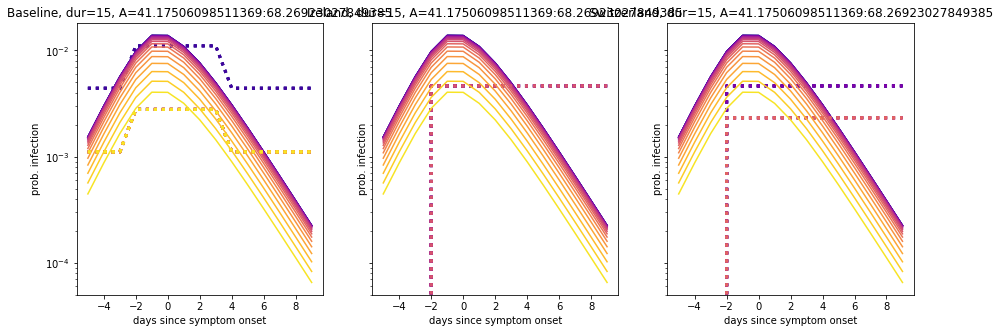

In [25]:
attens = np.linspace(40, 80, 10, endpoint=True)
symptoms = np.arange(-12,12)
#durations = np.array([15,1*60,4*60,8*60])

attens, durations, symptoms = make_inputs()

duration = 15
params = ModelParams()

config_list = [config_baseline, config_ireland, config_swiss]
n = len(config_list)
fig, axs = plt.subplots(1,n, figsize=(5*n,5), sharex=True, sharey=True)
axs = np.reshape(axs, (n,))
params = ModelParams()
for i, config in enumerate(config_list):
  plot_risk_vs_symptoms(attens, duration, symptoms, config, params, axs[i])

### Compare hypothetical variants

In [26]:
inf_levels1, inf_weights1 = make_infectiousness_params_v1()
inf_levels2, inf_weights2 = make_infectiousness_params_v2()
ble_thresholds1, ble_weights1 = make_ble_params_v1()
ble_thresholds2, ble_weights2 = make_ble_params_v2()

config_inf1_ble1 = RiskConfig(ble_thresholds = ble_thresholds1,
                           ble_weights = ble_weights1,
                           inf_levels = inf_levels1,
                           inf_weights = inf_weights1,
                           name = 'inf1_ble1')


config_inf2_ble1 = RiskConfig(ble_thresholds = ble_thresholds1,
                           ble_weights = ble_weights1,
                           inf_levels = inf_levels2,
                           inf_weights = inf_weights2,
                           name = 'inf2_ble1')


config_inf1_ble2 = RiskConfig(ble_thresholds = ble_thresholds2,
                           ble_weights = ble_weights2,
                           inf_levels = inf_levels1,
                           inf_weights = inf_weights1,
                           name = 'inf1_ble2')


config_inf2_ble2 = RiskConfig(ble_thresholds = ble_thresholds2,
                           ble_weights = ble_weights2,
                           inf_levels = inf_levels2,
                           inf_weights = inf_weights2,
                           name = 'inf2_ble2')

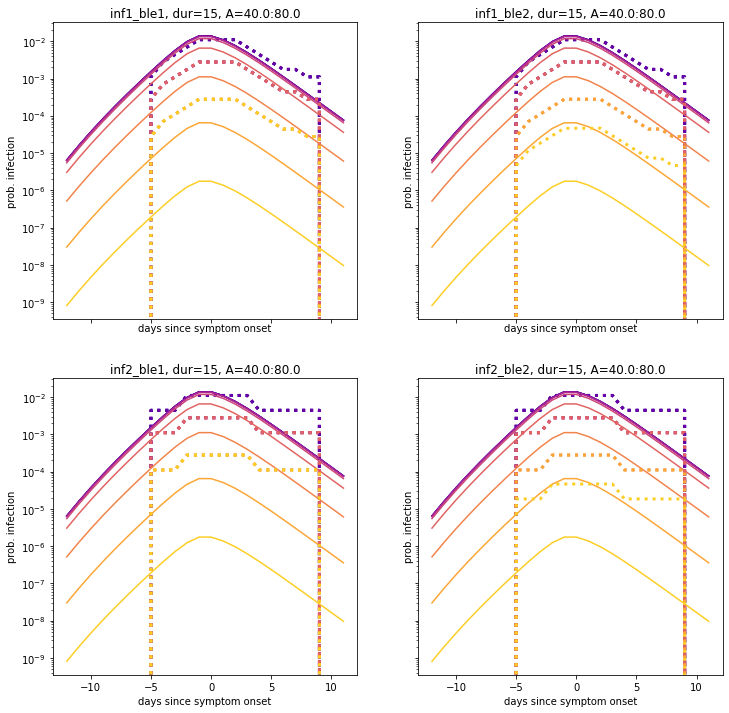

In [27]:
attens = np.linspace(40, 80, 10, endpoint=True)
symptoms = np.arange(-12,12)
#durations = np.array([15,1*60,4*60,8*60])
duration = 15
params = ModelParams()

config_list = [config_inf1_ble1, config_inf1_ble2, config_inf2_ble1, config_inf2_ble2]
fig, axs = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)
axs = np.reshape(axs, (4,))
for i, config in enumerate(config_list):
  plot_risk_vs_symptoms(attens, duration, symptoms, config, params, axs[i])

## Plot ROC curves



We compute the true and approximate infection probabilities, p(y=1|x_i) and q(y=1|x_i), on a 3d grid of inputs x_i. We convert p(y=1|x_i) into a binary label by comparing to a threshold corresponding to an "exposure". We then compute ROC curves.

CDC also has a [precise definition](https://www.cdc.gov/coronavirus/2019-ncov/php/contact-tracing/contact-tracing-plan/contact-tracing.html#:~:text=For%20COVID%2D19%2C%20a%20close,time%20the%20patient%20is%20isolated.) of what constitutes an "exposure":

* "For COVID-19, a close contact is defined as any individual who was within 6 feet of an infected person for at least 15 minutes starting from 2 days before illness onset."



In [28]:
def compute_exposure_threshold(params, duration=15, distance=2, symptom_onset=-2):
  atten = dist_to_atten(distance, params.ble_params)
  pthresh = prob_infection_batch(atten, duration, symptom_onset, params)
  return pthresh

params = ModelParams()
pthresh_cdc = compute_exposure_threshold(params)
print(pthresh_cdc)

0.009574522000898034


In [29]:

def make_curves_batch(attens, durations, symptoms, config, params):
  vals = itertools.product(durations, attens, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  durations_grid = X[:,0]
  attens_grid = X[:,1]
  sym_grid = np.array(X[:,2], dtype=int)
  ps = prob_infection_batch(attens_grid, durations_grid, sym_grid, params)
  rs = risk_score_batch(attens_grid, durations_grid, sym_grid, config)
  return ps, rs


In [30]:
RocResults = namedtuple('RocRresults', 'fpr tpr thresholds auc')

def compute_ROC_curve_struct(params, config,  pthresh=pthresh_cdc):
  attens, durations, symptoms = make_inputs()
  ps, qs = make_curves_batch(attens, durations, symptoms, config, params)
  yhat = (ps > pthresh)
  fpr, tpr, thresholds = metrics.roc_curve(yhat, qs)
  auc = metrics.auc(fpr, tpr)
  results = RocResults(fpr, tpr, thresholds, auc)
  return results


In [31]:
def plot_ROC_curves_struct(params, config_list, target_fpr=0.1, pthresh=pthresh_cdc, debug=False):
  n = len(config_list)
  fig, axs = plt.subplots(1,n, figsize=(5*n,5), sharex=True, sharey=True)
  for i, config in enumerate(config_list):
    res = compute_ROC_curve_struct(params, config, pthresh)
    ax = axs[i]
    ax.plot(res.fpr, res.tpr, 'o-', label="ROC curve")
    ax.set_title('AUC={:0.3f}, config={}'.format(res.auc, config.name))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

    target_thresh, target_tpr = find_operating_threshold(res.fpr, res.tpr, res.thresholds, target_fpr)
    ax.plot(target_fpr, target_tpr, 'r*', markersize=15)
    dx = 0.05
    dy = -0.07
    txt = 'FPR: {:0.3f}\n TPR: {:0.3f}\n Thresh: {:0.3f}'.format(
          target_fpr, target_tpr, target_thresh)
    ax.text(target_fpr + dx, target_tpr + dy, txt)
    
    if debug:
      ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
      step = 2
      for x, y, txt in zip(res.fpr[::step], res.tpr[::step], res.thresholds[::step]):
        ax.annotate(np.round(txt,2), (x, y-0.04))  

In [32]:

def find_operating_threshold(fpr, tpr, thresholds, target_fpr):
  thresh = np.interp(target_fpr, fpr, thresholds)
  target_tpr = np.interp(target_fpr, fpr, tpr)
  return thresh, target_tpr

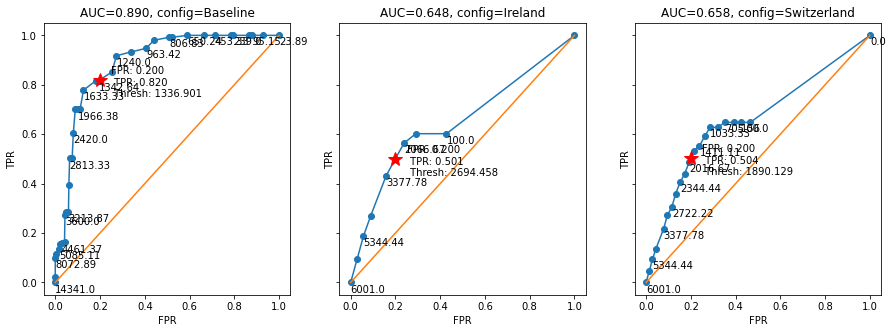

In [33]:
config_list = [config_baseline, config_ireland, config_swiss]
params = ModelParams()
plot_ROC_curves_struct(params, config_list, target_fpr=0.2, debug=True)

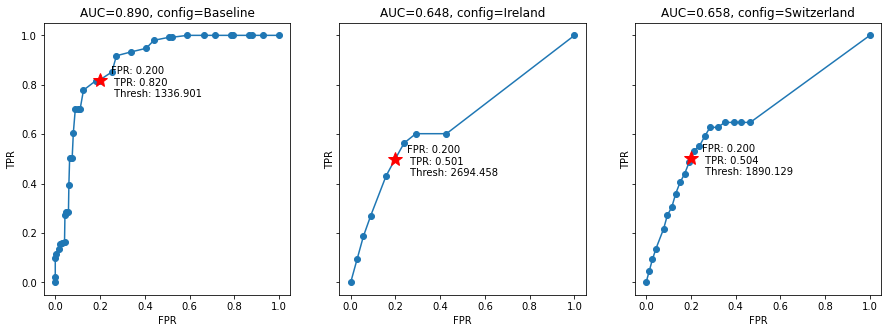

In [34]:
config_list = [config_baseline, config_ireland, config_swiss]
params = ModelParams()
plot_ROC_curves_struct(params, config_list, target_fpr=0.2)

## Plot ROC curves with error bars 



In [35]:
def make_curves_batch_noise(attens, durations, symptoms, config, params):
  distances = atten_to_dist(attens, params.ble_params)
  attens = dist_to_atten_sample(distances, params.ble_params)
  ps, rs = make_curves_batch(attens, durations, symptoms, config, params)
  return ps, rs



In [36]:
RocResultsErrorBars = namedtuple(
    'RocResultErrorBars', 
    'fpr tpr thresholds auc median_fpr median_tpr tprs_lo tprs_hi median_auc std_auc auc_lo auc_hi')


def compute_ROC_curve_with_errorbars_struct(params, config,  pthresh=pthresh_cdc, nsamples=20):
  attens, durations, symptoms = make_inputs()
  tprs = []
  aucs = []
  median_fpr = np.linspace(0, 1, 100)
  np.random.seed(0)
  for j in range(nsamples):
    ps, qs = make_curves_batch_noise(attens, durations, symptoms, config, params)
    yhat = (ps > pthresh)
    fpr, tpr, thresholds = metrics.roc_curve(yhat, qs)
    auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(median_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)
  median_tpr = np.median(tprs, axis=0)
  median_tpr[-1] = 1.0
  median_auc = metrics.auc(median_fpr, median_tpr)
  auc_lo = np.quantile(aucs, 0.025, axis=0)
  auc_hi = np.quantile(aucs, 0.975, axis=0)
  std_auc = np.std(aucs)
  tprs_hi = np.quantile(tprs, 0.025, axis=0)
  tprs_lo = np.quantile(tprs, 0.975, axis=0)
  res = compute_ROC_curve_struct(params, config, pthresh)
  results = RocResultsErrorBars(res.fpr, res.tpr, res.thresholds, res.auc, 
                                median_fpr, median_tpr, tprs_lo, tprs_hi,
                                median_auc, std_auc, auc_lo, auc_hi)
  return results




In [37]:
def plot_ROC_curves_with_errorbars_struct(params, config_list, target_fpr=0.1, pthresh=pthresh_cdc, nsamples=20):
  n = len(config_list)
  fig, axs = plt.subplots(1,n, figsize=(5*n,5), sharex=True, sharey=True)
  for i, config in enumerate(config_list):
    res = compute_ROC_curve_with_errorbars_struct(params, config,  pthresh, nsamples)
    ax = axs[i]
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.8)
    ax.plot(res.median_fpr, res.median_tpr, color='red', lw=2, alpha=0.8)
    ax.set_title('AUC: {:0.3f} [{:0.3f}, {:0.3f}], noise={:0.2f}\n config={}'.format(
        res.median_auc, res.auc_lo, res.auc_hi, params.ble_params.sigma, config.name))
    #ax.set_title('AUC={:0.3f}-{:0.3f}, sigma={:0.3f}\n config={}'.format(
    #    res.auc_lo, res.auc_hi, params.ble_params.sigma, config.name))
    
    target_thresh, target_tpr = find_operating_threshold(res.fpr, res.tpr, res.thresholds, target_fpr)
    ax.plot(target_fpr, target_tpr, 'r*', markersize=15)
    dx = 0.05
    dy = -0.07
    txt = 'FPR: {:0.3f}\n TPR: {:0.3f}\n Thresh: {:0.3f}'.format(
          target_fpr, target_tpr, target_thresh)
    ax.text(target_fpr + dx, target_tpr + dy, txt)

    ax.fill_between(res.median_fpr, res.tprs_lo, res.tprs_hi, color='grey', alpha=0.4,
                  label=r'$\pm$ 1 std. dev.')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

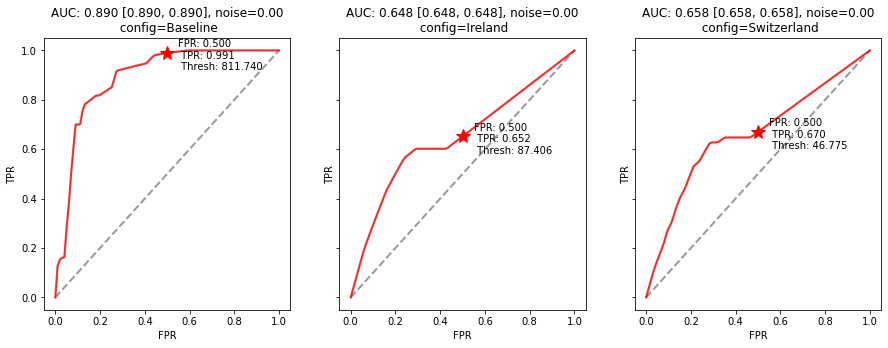

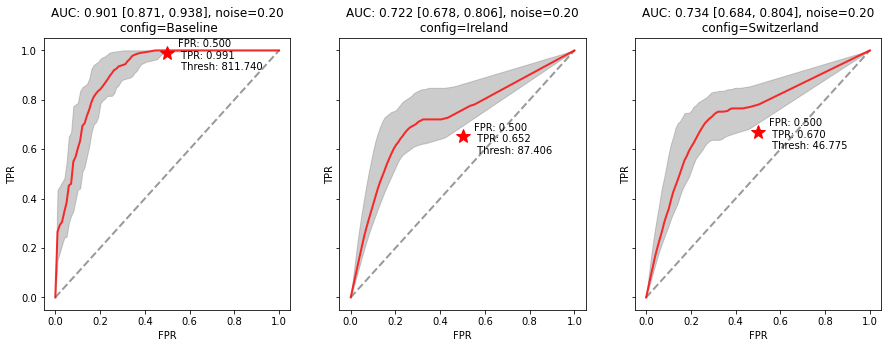

In [38]:
config_list = [config_baseline, config_ireland, config_swiss]
sigmas = [0, 0.2]
n = len(sigmas)
for  i in range(n):
  params = ModelParams(ble_params=BleParams(sigma=sigmas[i]))
  plot_ROC_curves_with_errorbars_struct(params, config_list, target_fpr=0.5)

# Colab sliders 

In [39]:
#@title # Choose risk score configuration 


#@markdown ## Attenuation weight (%)
immediate = 90 #@param {type:"slider", min:0, max:100, step:1}
near = 80 #@param {type:"slider", min:0, max:100, step:1}
medium = 70 #@param {type:"slider", min:0, max:100, step:1}
other = 60 #@param {type:"slider", min:0, max:100, step:1}
atten_weights = [immediate, near, medium, other]

#@markdown ---

#@markdown ## Attenuation thresholds (dB)
#@markdown Please make sure that each successive threshold is equal to or less
#@markdown than the previous.
immediate_near = 60 #@param {type:"slider", min:0, max:100, step:1}
near_medium = 70 #@param {type:"slider", min:0, max:100, step:1}
medium_far = 80 #@param {type:"slider", min:0, max:100, step:1}
atten_thresholds = [immediate_near, near_medium, medium_far]

#@markdown ---

#@markdown ## Infectiousness weight (%)
standard = 30 #@param {type:"slider", min:0, max:100, step:1}
high = 70 #@param {type:"slider", min:0, max:100, step:1}
inf_weights = [0, standard, high]

#@markdown ---

#@markdown ## Symptom onset (days since onset)
minus_14 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_13 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_12 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_11 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_10 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_09 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_08 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_07 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_06 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_05 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_04 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_03 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_02 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_01 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
day_zero = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_01 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_02 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_03 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_04 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_05 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_06 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_07 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_08 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_09 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_10 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_11 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_12 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_13 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_14 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_15 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}

symptom_onset = [minus_14, minus_13, minus_12, minus_11, minus_10, minus_09,
                 minus_08, minus_07, minus_06, minus_05, minus_04, minus_03,
                 minus_02, minus_01, day_zero, plus_01, plus_02, plus_03,
                 plus_04, plus_05, plus_06, plus_07, plus_08, plus_09, plus_10,
                 plus_11, plus_12, plus_13, plus_14]


import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output


def infectiousness_levels_from_gui():
  levels = []
  for index, level in enumerate(symptom_onset):
    if level == 'Drop':
      levels.append(0)
    elif level == 'Standard':
      levels.append(1)
    else:
      levels.append(2)
  return levels

config_custom = RiskConfig(
    ble_thresholds = np.array(atten_thresholds),
    ble_weights = np.array(atten_weights),
    inf_weights = np.array(inf_weights),
    inf_levels = np.array(infectiousness_levels_from_gui()),
    name = 'Custom')





In [40]:
#@title # Choose target FPR


#@markdown ## Desired false positive rate
#@markdown Default = 0.1
target_fpr_custom = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}





In [41]:
#@title # Choose simulation parameters


#@markdown ## Attenuation
#@markdown ### Functional form of dose vs distance
#@markdown Default = quadratic
distance_fun = 'sigmoid' #@param ['quadratic', 'sigmoid'] {type:"string"}

#@markdown ### Sigmoid distance parameters
#@markdown Default = 4
inflection = 4 #@param {type:"slider", min:0.1, max:10, step:0.1}
#@markdown Default = 2
slope = 1 #@param {type:"slider", min:0.1, max:5, step:0.1}


#@markdown ### Quadratic distance parameters
#@markdown Default = 1
Dmin = 2.2 #@param {type:"slider", min:0.5, max:5, step:0.1}



#@markdown ### Bluetooth Noise 
#@markdown Default = 0.02
sigma = 0.02 #@param {type:"slider", min:0, max:0.5, step:0.01}


#@markdown ## Infectiousness
#@markdown ### Functional form
#@markdown Default = skew-logistic
infectiousness_fun = 'skew-logistic' #@param ['skew-logistic', 'gaussian'] {type:"string"}



params_custom = ModelParams(
    distance_fun = distance_fun,
    distance_Dmin = Dmin,
    distance_slope = slope,
    distance_inflection = inflection,
    ble_params = BleParams(sigma = sigma),
    infectiousness_fun = infectiousness_fun)


In [42]:
#@title # Choose definition of positive exposure event (for ROC)

#@markdown ## Duration
#@markdown Default = 15 (minutes)
duration_threshold = 4 #@param {type:"slider", min:0, max:30, step:1}


#@markdown ## Distance
#@markdown Default = 2 (meters)
distance_threshold = 2 #@param {type:"slider", min:0, max:10, step:0.1}


#@markdown ## Symptom onset
#@markdown Default = -2 (days)
onset_threshold = -2 #@param {type:"slider", min:-14, max:14, step:1}

pthresh_custom = compute_exposure_threshold(params_custom)

## Plotting code

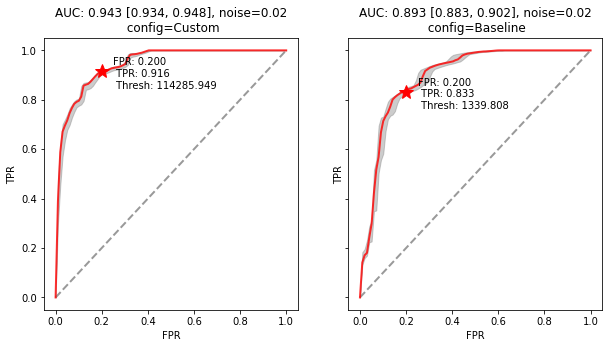

In [43]:
config_list = [config_custom, config_baseline]
if params_custom.ble_params.sigma > 0:
  plot_ROC_curves_with_errorbars_struct(params_custom, config_list, target_fpr=target_fpr_custom, pthresh=pthresh_custom)
else:
  plot_ROC_curves_struct(params_custom, config_list, target_fpr=target_fpr_custom, pthresh=pthresh_custom)


# JS Sliders


In [44]:
import IPython
from google.colab import output
import json


In [45]:
#levels, weights = make_infectiousness_params_v2()

class NumpyEncoder(json.JSONEncoder):
  """ Special json encoder for numpy types """
  def default(self, obj):
    if isinstance(obj, np.integer):
      return int(obj)
    elif isinstance(obj, np.floating):
      return float(obj)
    elif isinstance(obj, np.ndarray):
      return obj.tolist()
    return json.JSONEncoder.default(self, obj)



In [47]:
HTML = '''
  <link href='https://fonts.googleapis.com/css?family=Roboto+Slab:400,500,700|Roboto:700,500,300' rel='stylesheet' type='text/css'>  
  <link rel='stylesheet' href='https://roadtolarissa.com/colab-sliders/style.css?cache=6'>
  <script src='https://roadtolarissa.com/colab-sliders/d3_.js'></script>

  <script>window.ENABLE_DRAG_LINES = false</script>

  <div class='graph'></div>

  <script src='https://roadtolarissa.com/colab-sliders/script.js?cache=6'></script>
  <script Xsrc='https://roadtolarissa.com/colab-sliders/watch-files.js?cache=6'></script>
'''

  
def extract_pthresh_from_js(js_config):
  distance = js_config['distance']
  duration = js_config['duration']
  onset = js_config['onset']
  atten = dist_to_atten(distance, params_custom.ble_params)
  pthresh = prob_infection_batch(atten, duration, onset, params_custom)
  return pthresh

def parse_js_config(js_config):
  return RiskConfig(
    ble_thresholds = np.array(js_config['atten_thresholds']),
    ble_weights = np.array(js_config['atten_weights']),
    inf_weights = np.array(js_config['inf_weights']),
    inf_levels = np.array(js_config['inf_levels']),
    name = js_config['name']
  )

def roc_to_dict_struct(config, js_config):
  pthresh = extract_pthresh_from_js(js_config)
  res =  compute_ROC_curve_struct(params, config,  pthresh=pthresh)
  return {'fpr': res.fpr, 'tpr': res.tpr, 'thresholds': res.thresholds, 'auc': res.auc}

def error_bars_to_dict_struct(config, js_config, nsamples=20):
  params = ModelParams(ble_params = BleParams(sigma = js_config['sigma']))
  pthresh = extract_pthresh_from_js(js_config)
  res = compute_ROC_curve_with_errorbars_struct(params, config, pthresh=pthresh, nsamples=nsamples)
  target_fpr = np.arange(0, 1, .01)
  target_thresh, target_tpr = find_operating_threshold(res.fpr, res.tpr, res.thresholds, target_fpr)

  return {'fpr': res.median_fpr, 'tpr': res.median_tpr, 'tprs_lo': res.tprs_lo, 'tprs_hi': res.tprs_hi, 
          'median_auc': res.median_auc, 'auc_lo': res.auc_lo, 'auc_hi': res.auc_hi, 'target_fpr': target_fpr,
          'target_thresh': target_thresh, 'target_tpr': target_tpr
          }


def py_drag_end(js_config):
  custom_config = parse_js_config(js_config)
  custom_dict  = error_bars_to_dict_struct(custom_config, js_config)
  default_dict = [] #error_bars_to_dict_struct(config_default, js_config)
  outjson = json.dumps([custom_dict, default_dict], cls=NumpyEncoder)
  output.eval_js('js_drag_end({})'.format(outjson))
output.register_callback('py_drag_end', py_drag_end)

def py_drag_start(js_configs):
  custom_dicts = []
  for js_config in js_configs:
    custom_config = parse_js_config(js_config)
    custom_dict  = roc_to_dict_struct(custom_config, js_config)

    custom_dicts.append(custom_dict)
  outjson = json.dumps(custom_dicts, cls=NumpyEncoder)
  output.eval_js('js_drag_start({})'.format(outjson))
output.register_callback('py_drag_start', py_drag_start)


IPython.display.display(IPython.display.HTML(HTML))